## Jupyter notebook for analysing air quality data from China 

This notebook loads data on air quality from Chinese ground stations from 2016 onwards. This is based on a set of .csv files that contains hourly data from all stations by year. There is a seperate excel file that lists the individual ground sites by a numeric identifier [e.g. 1151A] according to site name and region.

The steps in this notebook are as follows:

 - Load excel sheet with city information. Extract all site names for a given region
 - Use those site names AND pollutant of interest to combine yearly data into one dataframe
 - Assess the change in diurnal profiles from a particular site, or sites.
 - Plot the time series data for the given pollutant for all sites in your chosen region
 - Generate a correlation coefficient plot for all sites.


In [1]:
import pandas as pd
import os
import glob
import numpy as np
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime

from google.colab import drive
drive.mount('/content/drive')


In [10]:
#Load in the list of sites
data = pd.read_excel(r'/content/drive/MyDrive/Air quality data in China/Sites_modifed.xlsx')
data.head(25)

,Site Number,Site Name,Region,Longitude,Latitude
0,1142A,十五厂,上海,121.478,31.2036
1,1143A,虹口,上海,121.467,31.3008
2,1144A,徐汇上师大,上海,121.412,31.1654
3,1145A,杨浦四漂,上海,121.536,31.2659
4,1146A,青浦淀山湖,上海,120.978,31.0935
5,1147A,静安监测站,上海,121.425,31.2261
6,1148A,浦东川沙,上海,121.703,31.1907
7,1149A,浦东新区监测站,上海,121.533,31.2284
8,1150A,浦东张江,上海,121.577,31.2071
9,NaN,NaN,NaN,NaN,NaN


In [11]:
# Extract all site names for a Nanjing
Nanjing_site_numbers = data[data['Region'] == '南京']['Site Number'].values
print(Nanjing_site_numbers)

['1151A' '1152A' '1153A' '1154A' '1155A' '1156A' '1157A' '1158A' '1159A']


In [20]:
import numpy
Nanjing_latlon_pairs = data[data['Region'] == '南京'][['Latitude','Longitude']].drop_duplicates()
Nanjing_latlon_pairs = Nanjing_latlon_pairs.dropna()
Nanjing_latlon_pairs

,Latitude,Longitude
11,32.1083,118.803
12,32.0572,118.749
13,32.0723,118.778
14,32.0144,118.777
15,32.0314,118.803
16,32.0775,118.795
17,32.0878,118.626
18,32.0092,118.737
19,32.1050,118.907


Currently the map plotting isn't working on Colab, it doesn't seem to be able to download the map data it just says "oh no I can't find the map data"

In [ ]:
!apt-get -qq install python-cartopy python3-cartopy

FileNotFoundError: ignored

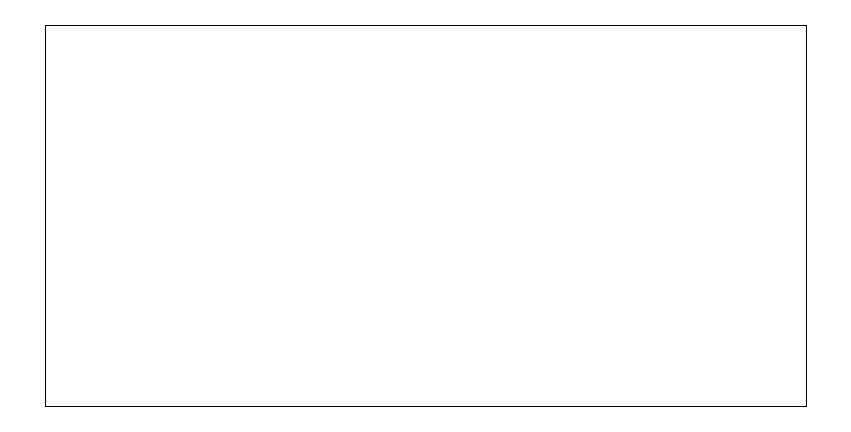

In [29]:
#plot all sites on a map
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
lat1, lon1, lat2, lon2 = 80, 140, 15, 40, 
ax.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.Geodetic())

#cp=plt.scatter(unique_latlon_pairs.Longitude, unique_latlon_pairs.Latitude,linewidth=2, s=0.01, marker='.',
#         transform=ccrs.PlateCarree(),
#        )

plt.scatter(Nanjing_latlon_pairs.Longitude,Nanjing_latlon_pairs.Latitude,color='yellow',transform=ccrs.PlateCarree())


#plt.colorbar(cp,fraction=0.034, pad=0.04)
#ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
#ax.add_feature(cartopy.feature.COASTLINE)
#ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
fig.set_size_inches(10, 10)

plt.show()



In [30]:
column_to_select = Nanjing_site_numbers.tolist()
column_to_select.append('date')
column_to_select.append('hour')
column_to_select.append('type')
print(column_to_select)

['1151A', '1152A', '1153A', '1154A', '1155A', '1156A', '1157A', '1158A', '1159A', 'date', 'hour', 'type']


In [34]:
import pdb
from datetime import datetime, timedelta

# Now let us extract data from a specific site, namely Nanjing. 
# For this Im going to manually 
folder_names = ['20160101-20161231','20170101-20171231','20180101-20181231','20190101-20191231','20200101-20201128']
#data_path = r'C:\Users\mbcx5jt5\Dropbox (The University of Manchester)\Air quality data in China'  #Laptop version
data_path = r'/content/drive/MyDrive/Air quality data in China/'  #Colab version
data_add = []

In [38]:
#first_folder = folder_names[0] #Uncomment to just load first directory
#first_folder = [first_folder]  #Uncomment to just load first directory
#for sub_directory in first_folder: #Uncomment to just load first directory
for sub_directory in folder_names:  #Uncomment to load all directories
    path_to_thisdirectory = os.path.join(data_path,sub_directory)
    print('Loading files from ' + path_to_thisdirectory)
    data_files = glob.glob(os.path.join(path_to_thisdirectory,'*.csv'))
    #pdb.set_trace()
    for filename in data_files:
        #breakpoint()
        try:
            data_df = pd.read_csv(filename, usecols = column_to_select)
            #data_df = pd.read_csv(filename)
            data_df = data_df[data_df['type'] == 'NO2']
            data_df['new_date'] = pd.to_datetime(data_df['date'],format='%Y%m%d')
            data_df['time_added'] = pd.to_timedelta(data_df['hour'],'h')
            data_df['timestamp'] = data_df['new_date'] + data_df['time_added']
            data_add.append(data_df)
        except:
            print("Trouble opening file , ", filename)
print('Finished loading files')

Loading files from /content/drive/MyDrive/Air quality data in China/20160101-20161231
Loading files from /content/drive/MyDrive/Air quality data in China/20170101-20171231
Loading files from /content/drive/MyDrive/Air quality data in China/20180101-20181231
Trouble opening file ,  /content/drive/MyDrive/Air quality data in China/20180101-20181231/china_sites_20181224.csv
Trouble opening file ,  /content/drive/MyDrive/Air quality data in China/20180101-20181231/china_sites_20181223.csv
Trouble opening file ,  /content/drive/MyDrive/Air quality data in China/20180101-20181231/china_sites_20181226.csv
Trouble opening file ,  /content/drive/MyDrive/Air quality data in China/20180101-20181231/china_sites_20181222.csv
Trouble opening file ,  /content/drive/MyDrive/Air quality data in China/20180101-20181231/china_sites_20181225.csv
Loading files from /content/drive/MyDrive/Air quality data in China/20190101-20191231
Loading files from /content/drive/MyDrive/Air quality data in China/20200101

In [42]:
data_add

[         date  hour type  ...   new_date      time_added           timestamp
 7    20160111     0  NO2  ... 2016-01-11 0 days 00:00:00 2016-01-11 00:00:00
 22   20160111     1  NO2  ... 2016-01-11 0 days 01:00:00 2016-01-11 01:00:00
 37   20160111     2  NO2  ... 2016-01-11 0 days 02:00:00 2016-01-11 02:00:00
 52   20160111     3  NO2  ... 2016-01-11 0 days 03:00:00 2016-01-11 03:00:00
 67   20160111     4  NO2  ... 2016-01-11 0 days 04:00:00 2016-01-11 04:00:00
 82   20160111     5  NO2  ... 2016-01-11 0 days 05:00:00 2016-01-11 05:00:00
 97   20160111     6  NO2  ... 2016-01-11 0 days 06:00:00 2016-01-11 06:00:00
 112  20160111     7  NO2  ... 2016-01-11 0 days 07:00:00 2016-01-11 07:00:00
 127  20160111     8  NO2  ... 2016-01-11 0 days 08:00:00 2016-01-11 08:00:00
 142  20160111     9  NO2  ... 2016-01-11 0 days 09:00:00 2016-01-11 09:00:00
 157  20160111    10  NO2  ... 2016-01-11 0 days 10:00:00 2016-01-11 10:00:00
 172  20160111    11  NO2  ... 2016-01-11 0 days 11:00:00 2016-0

In [39]:
#Put data from data_add from a list into a dataframe
complete_data = pd.concat(data_add, axis = 0, ignore_index=True)
# Now set the index to the datetime 
complete_data=complete_data.sort_values(by='timestamp',ascending=True)
complete_data=complete_data.set_index('timestamp') 
complete_data.head()

,date,hour,type,1151A,1152A,1153A,1154A,1155A,1156A,1157A,1158A,1159A,new_date,time_added
timestamp,,,,,,,,,,,,,,
2016-01-01 00:00:00,20160101,0,NO2,100.0,102.0,102.0,109.0,121.0,74.0,NaN,130.0,109.0,2016-01-01,0 days 00:00:00
2016-01-01 00:00:00,20160101,0,NO2,100.0,102.0,102.0,109.0,121.0,74.0,NaN,130.0,109.0,2016-01-01,0 days 00:00:00
2016-01-01 01:00:00,20160101,1,NO2,90.0,97.0,101.0,104.0,110.0,63.0,NaN,128.0,102.0,2016-01-01,0 days 01:00:00
2016-01-01 01:00:00,20160101,1,NO2,90.0,97.0,101.0,104.0,110.0,63.0,NaN,128.0,102.0,2016-01-01,0 days 01:00:00
2016-01-01 02:00:00,20160101,2,NO2,85.0,92.0,92.0,93.0,105.0,55.0,111.0,120.0,95.0,2016-01-01,0 days 02:00:00


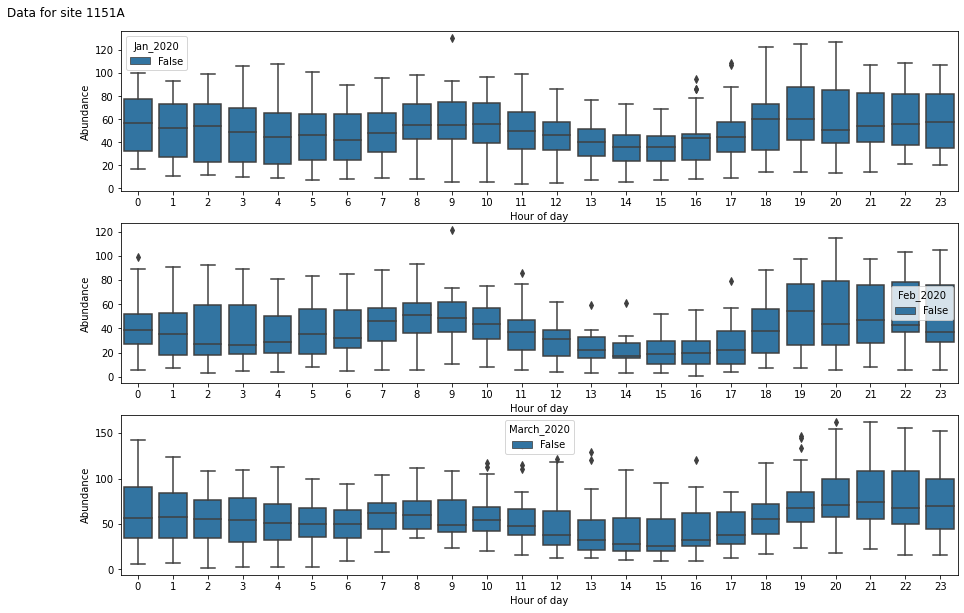

In [ ]:
# Now let us produce some diurnal plots of months this year, from individual sites.
# First we need to define some masks

mask_jan_20 = (complete_data.index.month == 1) & (complete_data.index > '2019-12-30')
mask_feb_20 = (complete_data.index.month == 2) & (complete_data.index > '2019-12-30')
mask_march_20 = (complete_data.index.month == 3) & (complete_data.index > '2019-12-30')
mask_jan = (complete_data.index.month == 1)
mask_feb = (complete_data.index.month == 2)
mask_march = (complete_data.index.month == 3) 

complete_data['Jan_2020'] = mask_jan_20
complete_data['Feb_2020'] = mask_feb_20
complete_data['March_2020'] = mask_march_20

f, ax = plt.subplots(3,1,figsize=(15, 10))
plt.text(0.02, 0.9, 'Data for site 1151A', fontsize=12, transform=plt.gcf().transFigure)
sns.boxplot(data=complete_data.loc[mask_jan],x=complete_data.loc[mask_jan].index.hour, y=complete_data.loc[mask_jan]['1151A'],hue='Jan_2020', ax=ax[0]).set(xlabel='Hour of day',ylabel='Abundance')
sns.boxplot(data=complete_data.loc[mask_feb],x=complete_data.loc[mask_feb].index.hour, y=complete_data.loc[mask_feb]['1151A'],hue='Feb_2020',ax=ax[1]).set(xlabel='Hour of day',ylabel='Abundance')
sns.boxplot(data=complete_data.loc[mask_march],x=complete_data.loc[mask_march].index.hour, y=complete_data.loc[mask_march]['1151A'],hue='March_2020',ax=ax[2]).set(xlabel='Hour of day',ylabel='Abundance')
plt.show()
#plt.savefig(download_path+"/"+local_authority+"/"+local_authority+"-"+station_name+"-"+entry+".png")
plt.close('all')
                                #plt.show()

In [ ]:
# Now we can also plot the change in daily mean concentrations

# Create a new dataframe with daily means
means = complete_data.groupby(pd.Grouper(freq='1D')).mean()
means.head()
# Now plot the variation in NO2 for all sites on one time series plot
#means.plot(x=means.index, y=site_number.tolist(), figsize=(10,5), grid=True)
#plt.show()


,date,hour,1151A,1152A,1153A,1154A,1155A,1156A,1157A,1158A,1159A,Jan_2020,Feb_2020,March_2020
timestamp,,,,,,,,,,,,,,
2016-01-01,20160101.0,11.5,79.250000,82.458333,102.375000,75.041667,85.416667,68.208333,86.578947,87.041667,75.458333,0.0,0.0,0.0
2016-01-02,20160102.0,11.5,88.000000,96.166667,126.000000,92.333333,113.000000,94.375000,97.826087,95.541667,100.333333,0.0,0.0,0.0
2016-01-03,20160103.0,11.5,76.291667,87.333333,112.250000,74.041667,92.291667,80.375000,86.000000,84.708333,93.833333,0.0,0.0,0.0
2016-01-04,20160104.0,11.5,74.739130,90.041667,104.541667,79.625000,74.458333,74.250000,66.041667,84.708333,73.916667,0.0,0.0,0.0
2016-01-05,20160105.0,11.5,36.333333,44.750000,63.958333,24.125000,34.333333,44.250000,27.791667,35.041667,34.916667,0.0,0.0,0.0


TypeError: descriptor 'date' requires a 'datetime.datetime' object but received a 'int'

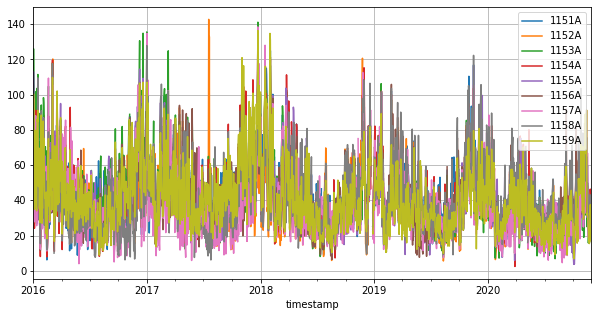

In [ ]:
ax = means.plot(y=site_number.tolist(), figsize=(10,5), grid=True)
ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2020, 11, 1)])
ax.set_xlabel("Date", size=14)
ax.set_ylabel(r'NO2 $\mu g.m^{-3}$', size=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
#plt.title('Validation data v. forecast ')
plt.legend(prop={"size":14},bbox_to_anchor=(1,1), loc="upper left");
plt.show()


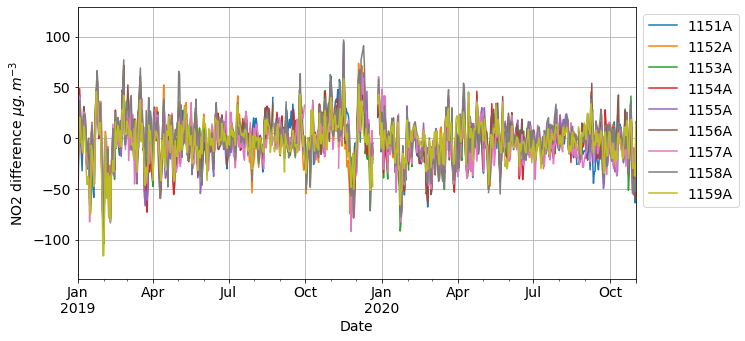

In [ ]:
df_diff = means[site_number.tolist()].diff(365)
ax = df_diff.plot(y=site_number.tolist(), figsize=(10,5), grid=True)
ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2020, 11, 1)])
ax.set_xlabel("Date", size=14)
ax.set_ylabel(r'NO2 difference $\mu g.m^{-3}$', size=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
#plt.title('Validation data v. forecast ')
plt.legend(prop={"size":14},bbox_to_anchor=(1,1), loc="upper left");
plt.show()


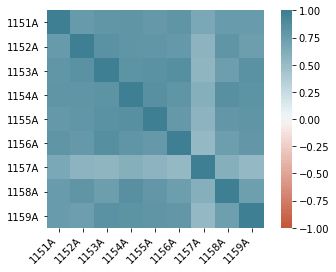

In [ ]:
corr = complete_data[site_number.tolist()].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Now need to make a part where we save the extracted data as a CSV, something like that. So it's easy to have just one site data
